# Import Statements

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# Opening the File to see the list of parameters

### Pass 5.1

In [2]:
pass5file = '/home/rykore/pass5.1/2.63_3.45e-11_1000000_35_1.0_combined_rec.root'

with uproot.open(pass5file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype('>u8')
rec.nHitTot          | uint64_t                 | AsDtype(

### Pass 4

In [3]:
pass4file = '/home/rykore/pass4/2.63_3.45e-11_1000000_0_1.0_combined_rec.root'

with uproot.open(pass4file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.nFit             | uint64_t                 | AsDtype('>u8')
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype(

# Redefining variables based on what is needed

### Pass 5.1

In [4]:
dset = dict()

with uproot.open(pass5file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNNEnergy"] = t["rec.logNNEnergy"].array(library="np")  # reconstructed energy

In [5]:
initial_cuts_5 = dset["cuts"]
zenith_angle_5 = dset["zenithAngle"][initial_cuts_5]
true_log_E_5 = dset["logEnergy"][initial_cuts_5]
rec_log_nnE_5 = dset["logNNEnergy"][initial_cuts_5]
rec_prot_E_5 = dset["protonlheEnergy"][initial_cuts_5]
weights_5 = dset["weights"][initial_cuts_5]

In [6]:
len(dset["logNNEnergy"])
len(initial_cuts_5)

29035661

In [7]:
len(rec_log_nnE_5)

5185506

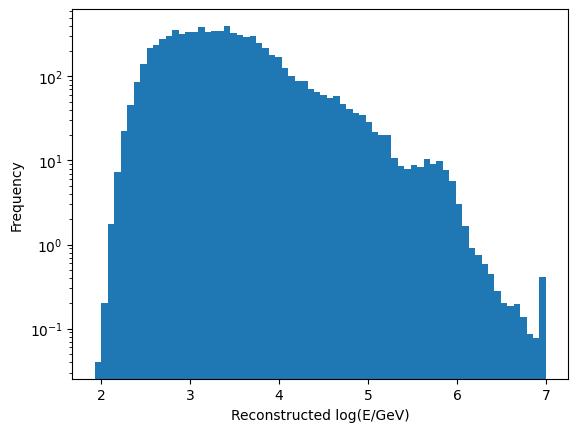

In [8]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(rec_log_nnE_5, bins = 70, log=True, weights = weights_5)
plt.xlabel("Reconstructed log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

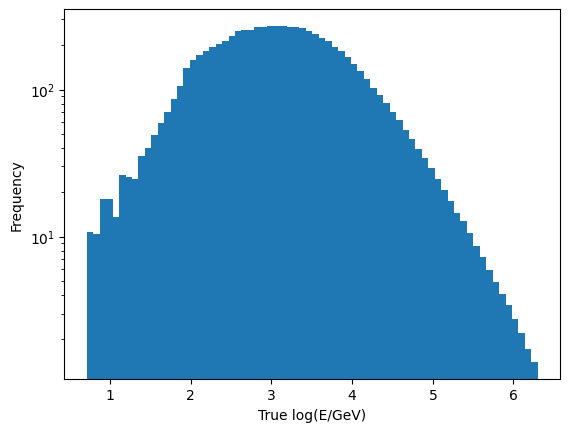

In [9]:
plt.hist(true_log_E_5, bins = 70, log=True, weights = weights_5)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

### Pass 4

In [10]:
dset = dict()

with uproot.open(pass4file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNnEnergy"] = t["rec.logNnEnergy"].array(library="np")  # reconstructed energy

In [11]:
initial_cuts_4 = dset["cuts"]
zenith_angle_4 = dset["zenithAngle"][initial_cuts_4]
true_log_E_4 = dset["logEnergy"][initial_cuts_4]
rec_log_nnE_4 = dset["logNnEnergy"][initial_cuts_4]
rec_prot_E_4 = dset["protonlheEnergy"][initial_cuts_4]
weights_4 = dset["weights"][initial_cuts_4]

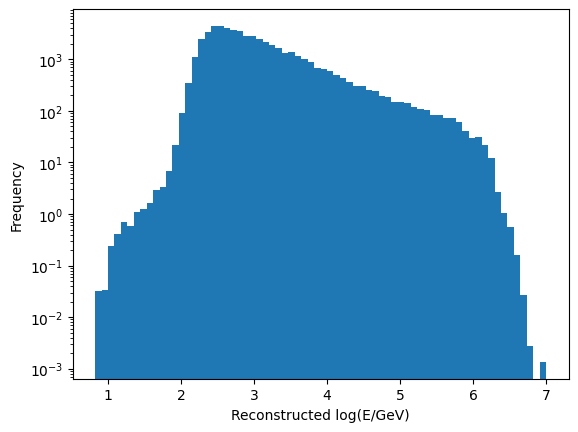

In [12]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(rec_log_nnE_4, bins = 70, log=True, weights = weights_4)
plt.xlabel("Reconstructed log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

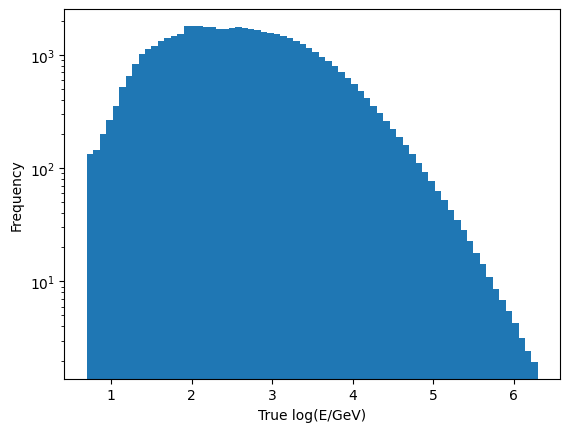

In [13]:
plt.hist(true_log_E_4, bins = 70, log=True, weights = weights_4)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

# Cutting and binning the Energy

In [14]:
# true cuts for pass 5.1
true_cut1_5 = np.logical_and(true_log_E_5 >= np.log10(1e3),true_log_E_5 < np.log10(1e4))
true_cut2_5 = np.logical_and(true_log_E_5 >= np.log10(1e4),true_log_E_5 < np.log10(3e4))
true_cut3_5 = np.logical_and(true_log_E_5 >= np.log10(3e4),true_log_E_5 < np.log10(5e4))
true_cut4_5 = np.logical_and(true_log_E_5 >= np.log10(5e4),true_log_E_5 <= np.log10(7e4))
true_cut5_5 = true_log_E_5 > np.log10(7e4)

In [15]:
# reconstructed cuts for pass 5.1
rec_cut1_5 = np.logical_and(rec_log_nnE_5 >= np.log10(1e3),rec_log_nnE_5 < np.log10(1e4))
rec_cut2_5 = np.logical_and(rec_log_nnE_5 >= np.log10(1e4),rec_log_nnE_5 < np.log10(3e4))
rec_cut3_5 = np.logical_and(rec_log_nnE_5 >= np.log10(3e4),rec_log_nnE_5 < np.log10(5e4))
rec_cut4_5 = np.logical_and(rec_log_nnE_5 >= np.log10(5e4),rec_log_nnE_5 <= np.log10(7e4))
rec_cut5_5 = rec_log_nnE_5 > np.log10(7e4)

In [16]:
# true cuts for pass 4
true_cut1_4 = np.logical_and(true_log_E_4 >= np.log10(1e3),true_log_E_4 < np.log10(1e4))
true_cut2_4 = np.logical_and(true_log_E_4 >= np.log10(1e4),true_log_E_4 < np.log10(3e4))
true_cut3_4 = np.logical_and(true_log_E_4 >= np.log10(3e4),true_log_E_4 < np.log10(5e4))
true_cut4_4 = np.logical_and(true_log_E_4 >= np.log10(5e4),true_log_E_4 <= np.log10(7e4))
true_cut5_4 = true_log_E_4 > np.log10(7e4)

In [17]:
# reconstructed cuts for pass 4
rec_cut1_4 = np.logical_and(rec_log_nnE_4 >= np.log10(1e3),rec_log_nnE_4 < np.log10(1e4))
rec_cut2_4 = np.logical_and(rec_log_nnE_4 >= np.log10(1e4),rec_log_nnE_4 < np.log10(3e4))
rec_cut3_4 = np.logical_and(rec_log_nnE_4 >= np.log10(3e4),rec_log_nnE_4 < np.log10(5e4))
rec_cut4_4 = np.logical_and(rec_log_nnE_4 >= np.log10(5e4),rec_log_nnE_4 <= np.log10(7e4))
rec_cut5_4 = rec_log_nnE_4 > np.log10(7e4)

### Pass 5.1

In [18]:
# true energy cuts pass 5.1

true_energy_cut1_5 = true_log_E_5[true_cut1_5]
true_energy_cut2_5 = true_log_E_5[true_cut2_5]
true_energy_cut3_5 = true_log_E_5[true_cut3_5]
true_energy_cut4_5 = true_log_E_5[true_cut4_5]
true_energy_cut5_5 = true_log_E_5[true_cut5_5]

true_energies_5 = [true_energy_cut1_5, true_energy_cut2_5, true_energy_cut3_5, true_energy_cut4_5, true_energy_cut5_5]

In [19]:
# reconstructed energy cuts pass 5.1

rec_energy_cut1_5 = rec_log_nnE_5[rec_cut1_5]
rec_energy_cut2_5 = rec_log_nnE_5[rec_cut2_5]
rec_energy_cut3_5 = rec_log_nnE_5[rec_cut3_5]
rec_energy_cut4_5 = rec_log_nnE_5[rec_cut4_5]
rec_energy_cut5_5 = rec_log_nnE_5[rec_cut5_5]

rec_energies_5 = [rec_energy_cut1_5, rec_energy_cut2_5, rec_energy_cut3_5, rec_energy_cut4_5, rec_energy_cut5_5]

In [20]:
# true weight cuts pass 5.1

true_weights_cut1_5 = weights_5[true_cut1_5]
true_weights_cut2_5 = weights_5[true_cut2_5]
true_weights_cut3_5 = weights_5[true_cut3_5]
true_weights_cut4_5 = weights_5[true_cut4_5]
true_weights_cut5_5 = weights_5[true_cut5_5]

true_weights_array_5 = [true_weights_cut1_5, true_weights_cut2_5, true_weights_cut3_5, true_weights_cut4_5, true_weights_cut5_5]

In [21]:
# reconstructed weight cuts pass 5.1

rec_weights_cut1_5 = weights_5[rec_cut1_5]
rec_weights_cut2_5 = weights_5[rec_cut2_5]
rec_weights_cut3_5 = weights_5[rec_cut3_5]
rec_weights_cut4_5 = weights_5[rec_cut4_5]
rec_weights_cut5_5 = weights_5[rec_cut5_5]

rec_weights_array_5 = [rec_weights_cut1_5, rec_weights_cut2_5, rec_weights_cut3_5, rec_weights_cut4_5, rec_weights_cut5_5]

In [22]:
# true zenith angle cuts pass 5.1

true_zenith_cut1_5 = zenith_angle_5[true_cut1_5]
true_zenith_cut2_5 = zenith_angle_5[true_cut2_5]
true_zenith_cut3_5 = zenith_angle_5[true_cut3_5]
true_zenith_cut4_5 = zenith_angle_5[true_cut4_5]
true_zenith_cut5_5 = zenith_angle_5[true_cut5_5]

true_zenith_array_5 = [true_zenith_cut1_5, true_zenith_cut2_5, true_zenith_cut3_5, true_zenith_cut4_5, true_zenith_cut5_5]

In [23]:
# reconstructed zenith angle cuts pass 5.1

rec_zenith_cut1_5 = zenith_angle_5[rec_cut1_5]
rec_zenith_cut2_5 = zenith_angle_5[rec_cut2_5]
rec_zenith_cut3_5 = zenith_angle_5[rec_cut3_5]
rec_zenith_cut4_5 = zenith_angle_5[rec_cut4_5]
rec_zenith_cut5_5 = zenith_angle_5[rec_cut5_5]

rec_zenith_array_5 = [rec_zenith_cut1_5, rec_zenith_cut2_5, rec_zenith_cut3_5, rec_zenith_cut4_5, rec_zenith_cut5_5]

### Pass 4

In [24]:
# true energy cuts pass 4

true_energy_cut1_4 = true_log_E_4[true_cut1_4]
true_energy_cut2_4 = true_log_E_4[true_cut2_4]
true_energy_cut3_4 = true_log_E_4[true_cut3_4]
true_energy_cut4_4 = true_log_E_4[true_cut4_4]
true_energy_cut5_4 = true_log_E_4[true_cut5_4]

true_energies_4 = [true_energy_cut1_4, true_energy_cut2_4, true_energy_cut3_4, true_energy_cut4_4, true_energy_cut5_4]

In [25]:
# reconstructed energy cuts pass 4

rec_energy_cut1_4 = rec_log_nnE_4[rec_cut1_4]
rec_energy_cut2_4 = rec_log_nnE_4[rec_cut2_4]
rec_energy_cut3_4 = rec_log_nnE_4[rec_cut3_4]
rec_energy_cut4_4 = rec_log_nnE_4[rec_cut4_4]
rec_energy_cut5_4 = rec_log_nnE_4[rec_cut5_4]

rec_energies_4 = [rec_energy_cut1_4, rec_energy_cut2_4, rec_energy_cut3_4, rec_energy_cut4_4, rec_energy_cut5_4]

In [26]:
# true weight cuts pass 4

true_weights_cut1_4 = weights_4[true_cut1_4]
true_weights_cut2_4 = weights_4[true_cut2_4]
true_weights_cut3_4 = weights_4[true_cut3_4]
true_weights_cut4_4 = weights_4[true_cut4_4]
true_weights_cut5_4 = weights_4[true_cut5_4]

true_weights_array_4 = [true_weights_cut1_4, true_weights_cut2_4, true_weights_cut3_4, true_weights_cut4_4, true_weights_cut5_4]

In [27]:
# reconstructed weight cuts pass 4

rec_weights_cut1_4 = weights_4[rec_cut1_4]
rec_weights_cut2_4 = weights_4[rec_cut2_4]
rec_weights_cut3_4 = weights_4[rec_cut3_4]
rec_weights_cut4_4 = weights_4[rec_cut4_4]
rec_weights_cut5_4 = weights_4[rec_cut5_4]

rec_weights_array_4 = [rec_weights_cut1_4, rec_weights_cut2_4, rec_weights_cut3_4, rec_weights_cut4_4, rec_weights_cut5_4]

In [28]:
# true zenith angle cuts pass 4

true_zenith_cut1_4 = zenith_angle_4[true_cut1_4]
true_zenith_cut2_4 = zenith_angle_4[true_cut2_4]
true_zenith_cut3_4 = zenith_angle_4[true_cut3_4]
true_zenith_cut4_4 = zenith_angle_4[true_cut4_4]
true_zenith_cut5_4 = zenith_angle_4[true_cut5_4]

true_zenith_array_4 = [true_zenith_cut1_4, true_zenith_cut2_4, true_zenith_cut3_4, true_zenith_cut4_4, true_zenith_cut5_4]

In [29]:
# reconstructed zenith angle cuts pass 4

rec_zenith_cut1_4 = zenith_angle_4[rec_cut1_4]
rec_zenith_cut2_4 = zenith_angle_4[rec_cut2_4]
rec_zenith_cut3_4 = zenith_angle_4[rec_cut3_4]
rec_zenith_cut4_4 = zenith_angle_4[rec_cut4_4]
rec_zenith_cut5_4 = zenith_angle_4[rec_cut5_4]

rec_zenith_array_4 = [rec_zenith_cut1_4, rec_zenith_cut2_4, rec_zenith_cut3_4, rec_zenith_cut4_4, rec_zenith_cut5_4]

# Weighted Quantile function
#### input:
values = log_E  \
quantiles = \[0.159, 0.841\] (array of what quantiles of the data you need) \
sample_weight = weights (apply cuts on weights as well so that the dimensions of both the arrays remain the same) \
values_sorted (if False, will sort the returned array)
#### output:
an interpolated array having the same dimensions as the quantiles array from the input that has the weighted values in the data at those specified quantiles

In [30]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

# Binning the zenith angle

In [31]:
# 180 degrees divided into 18 bins with each bin being 10 degrees
deltaz = np.radians(5)
zbins = np.arange(min(zenith_angle_5),max(zenith_angle_5), deltaz)
print(zbins)

[2.00000000e-04 8.74664626e-02 1.74732925e-01 2.61999388e-01
 3.49265850e-01 4.36532313e-01 5.23798776e-01 6.11065238e-01
 6.98331701e-01 7.85598163e-01 8.72864626e-01 9.60131089e-01
 1.04739755e+00 1.13466401e+00 1.22193048e+00 1.30919694e+00
 1.39646340e+00 1.48372986e+00]


# Plotting the average energy vs zenith angle

## True Energy

In [32]:
true_energies = [true_energies_4, true_energies_5]
true_weights_array = [true_weights_array_4, true_weights_array_5]
true_zenith_array = [true_zenith_array_4, true_zenith_array_5]
colors = ['black', 'royalblue']
titles = ['1 TeV to 10 TeV', '10 TeV to 30 TeV', '30 TeV to 50 TeV', '50 TeV to 70 TeV', 'More than 70 TeV']

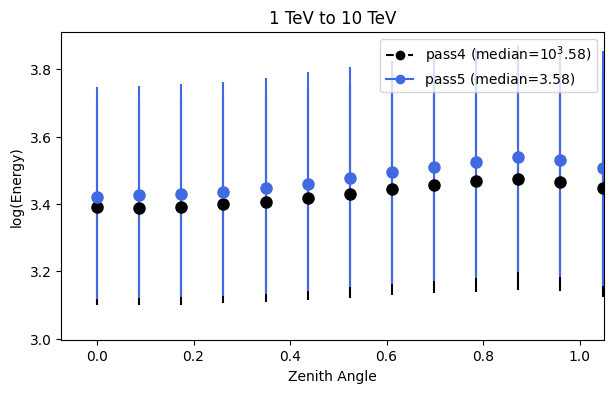

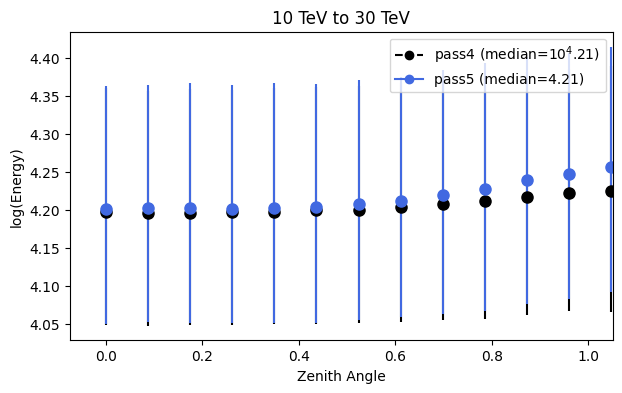

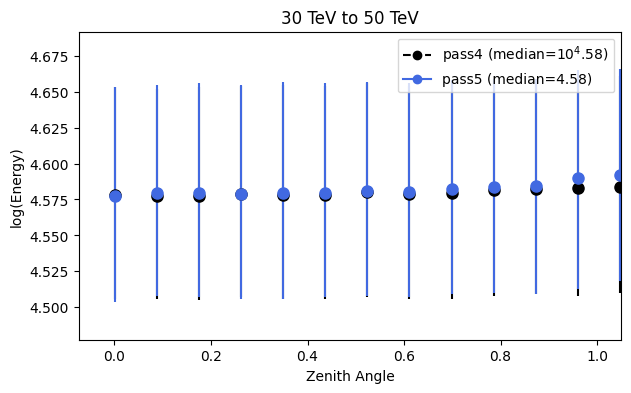

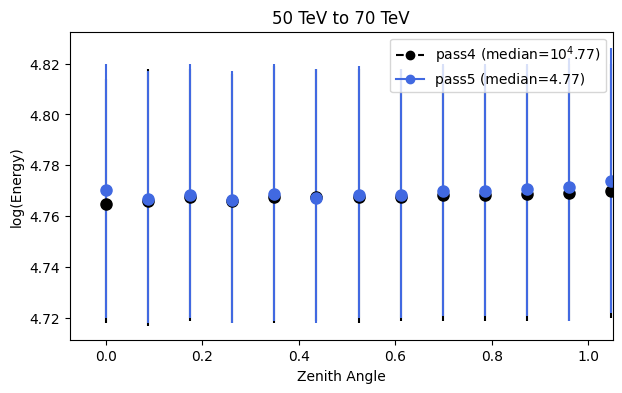

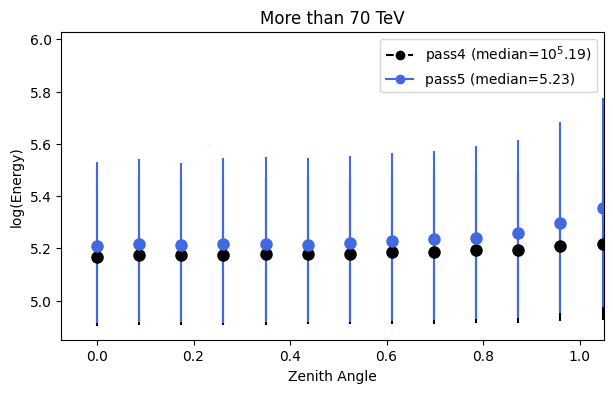

In [33]:
for i in range(5):  # Loop over the 5 cuts
    fig, ax = plt.subplots(figsize=(7, 4))
    medians = []

    for j, (energy_set, weight_set, zenith_set, color) in enumerate(zip(true_energies, true_weights_array, true_zenith_array, colors)):
        energy = energy_set[i]
        weight = weight_set[i]
        zenith = zenith_set[i]
        median_energy = np.median(energy)
        medians.append(median_energy)

        for z in zbins:
            zmin = z
            zmax = z + deltaz
            zcut = np.logical_and(zenith >= zmin, zenith <= zmax)

            if not sum(weight[zcut] > 0):
                continue

            avg_energy = np.average(energy[zcut], weights=weight[zcut])
            upper_quantile = weighted_quantile(energy[zcut], 0.841, sample_weight=weight[zcut])
            lower_quantile = weighted_quantile(energy[zcut], 0.159, sample_weight=weight[zcut])

            err_upper = upper_quantile - avg_energy
            err_lower = avg_energy - lower_quantile

            ax.errorbar(z, avg_energy, yerr=[[err_lower], [err_upper]], fmt='o', markersize=8, color=color, label=f'pass{4+j}' if z == zbins[0] else "")

    ax.set_xlabel('Zenith Angle')
    ax.set_ylabel('log(Energy)')
    ax.set_title(titles[i])
    ax.set_xlim(right = 1.05)  # 1.05 radians is 60 degrees
    
    proxy_pass4 = plt.Line2D([0], [0], linestyle='--', marker='o', color=colors[0])
    proxy_pass5 = plt.Line2D([0], [0], linestyle='-', marker='o', color=colors[1])
    ax.legend([proxy_pass4, proxy_pass5], [f'pass4 (median=$10^{medians[0]:.2f}$)', f'pass5 (median={medians[1]:.2f})'])
    
    plt.show()

## Reconstructed Energy

In [34]:
rec_energies = [rec_energies_4, rec_energies_5]
rec_weights_array = [rec_weights_array_4, rec_weights_array_5]
rec_zenith_array = [rec_zenith_array_4, rec_zenith_array_5]

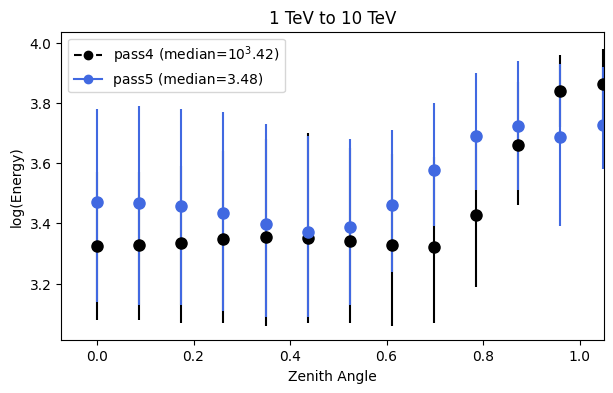

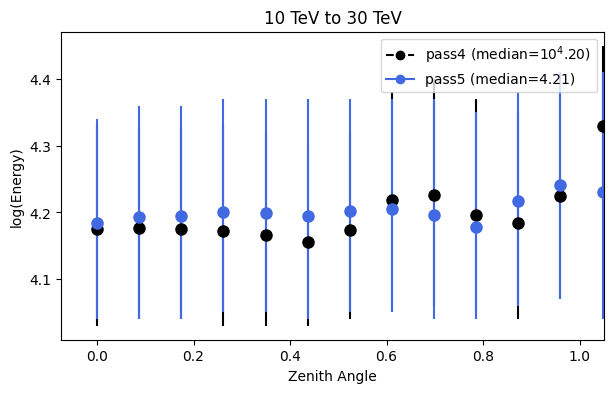

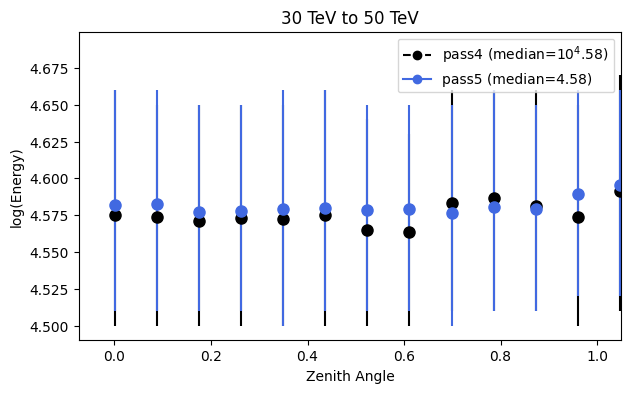

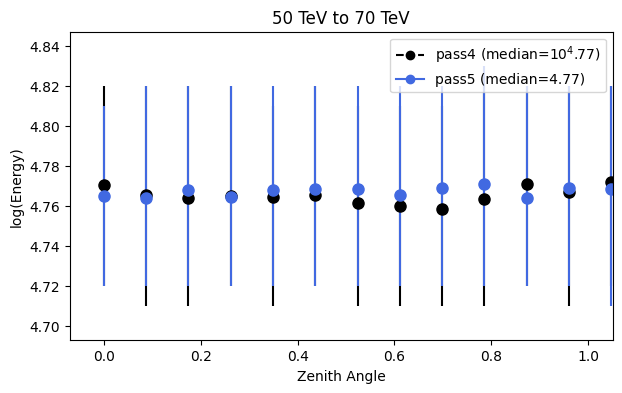

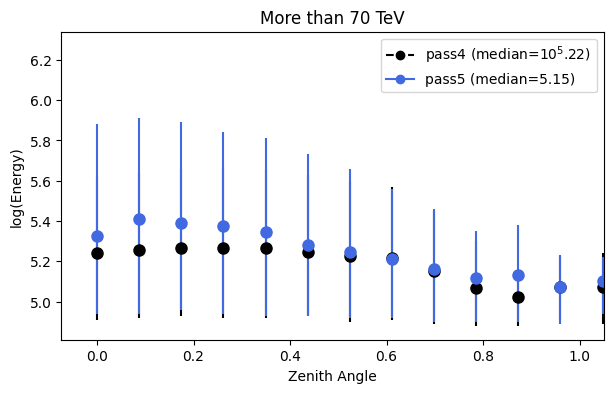

In [35]:
for i in range(5):  # Loop over the 5 cuts
    fig, ax = plt.subplots(figsize=(7, 4))
    medians = []

    for j, (energy_set, weight_set, zenith_set, color) in enumerate(zip(rec_energies, rec_weights_array, rec_zenith_array, colors)):
        energy = energy_set[i]
        weight = weight_set[i]
        zenith = zenith_set[i]
        median_energy = np.median(energy)
        medians.append(median_energy)

        for z in zbins:
            zmin = z
            zmax = z + deltaz
            zcut = np.logical_and(zenith >= zmin, zenith <= zmax)

            if not sum(weight[zcut] > 0):
                continue

            avg_energy = np.average(energy[zcut], weights=weight[zcut])
            upper_quantile = weighted_quantile(energy[zcut], 0.841, sample_weight=weight[zcut])
            lower_quantile = weighted_quantile(energy[zcut], 0.159, sample_weight=weight[zcut])

            err_upper = upper_quantile - avg_energy
            err_lower = avg_energy - lower_quantile

            ax.errorbar(z, avg_energy, yerr=[[err_lower], [err_upper]], fmt='o', markersize=8, color=color, label=f'pass{4+j}' if z == zbins[0] else "")

    ax.set_xlabel('Zenith Angle')
    ax.set_ylabel('log(Energy)')
    ax.set_title(titles[i])
    ax.set_xlim(right = 1.05)  # 1.05 radians is 60 degrees
    
    proxy_pass4 = plt.Line2D([0], [0], linestyle='--', marker='o', color=colors[0])
    proxy_pass5 = plt.Line2D([0], [0], linestyle='-', marker='o', color=colors[1])
    ax.legend([proxy_pass4, proxy_pass5], [f'pass4 (median=$10^{medians[0]:.2f}$)', f'pass5 (median={medians[1]:.2f})'])
    
    plt.show()

# Plotting the equation

\$ \frac{d \log{\phi} (E)}{\log{E}} = \gamma_{1} + (\gamma_{2} - \gamma_{1}) \frac{\left( \frac{E}{E_{o}} \right)^{\varepsilon}}{1 + \left( \frac{E}{E_{o}} \right)^{\varepsilon}}  \$

In [36]:
g1 = -2.52
g2 = -2.71
E0 = 3.87e4
eps = 3
def func(E):
    y = g1 + (g2 - g1)*((((E)/E0)**eps)/(1 + ((E)/E0)**eps))
    return y

In [37]:
specind = func(10**(log_E_5))

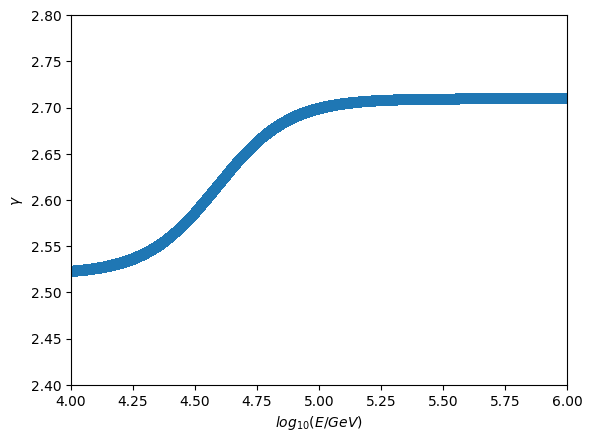

In [43]:
plt.scatter(log_E_5, np.abs(specind))
# plt.fill_between(log_E_5[:10000], 1 , alpha = 0.3)
plt.ylim(2.4, 2.8)
plt.xlim(4,6)
plt.xlabel("$ log_{10} (E/GeV) $")
plt.ylabel("$ \gamma $")
plt.show()